In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import tqdm
import warnings
import timm

warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

def set_seed(seed=0):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    
set_seed(7777)

In [2]:
import pretrainedmodels

### Data overview

In [3]:
train_df = pd.read_csv("train.csv")
train_df

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
...,...,...
9845,ffe5c306.jpg,w_2ceab05
9846,ffeaa7a4.jpg,w_b067417
9847,ffecec63.jpg,w_8b56cb1
9848,fff04277.jpg,w_2dcbf82


For train data we have a DataFrame with image names and ids. And of course for train and test we have images in separate folders.

In [6]:
print(f"There are {len(os.listdir('train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('test'))} images in test dataset.")

There are 9850 images in train dataset with 4251 unique classes.
There are 15610 images in test dataset.


25k images in train and 5k different whales!
Let's have a look at them

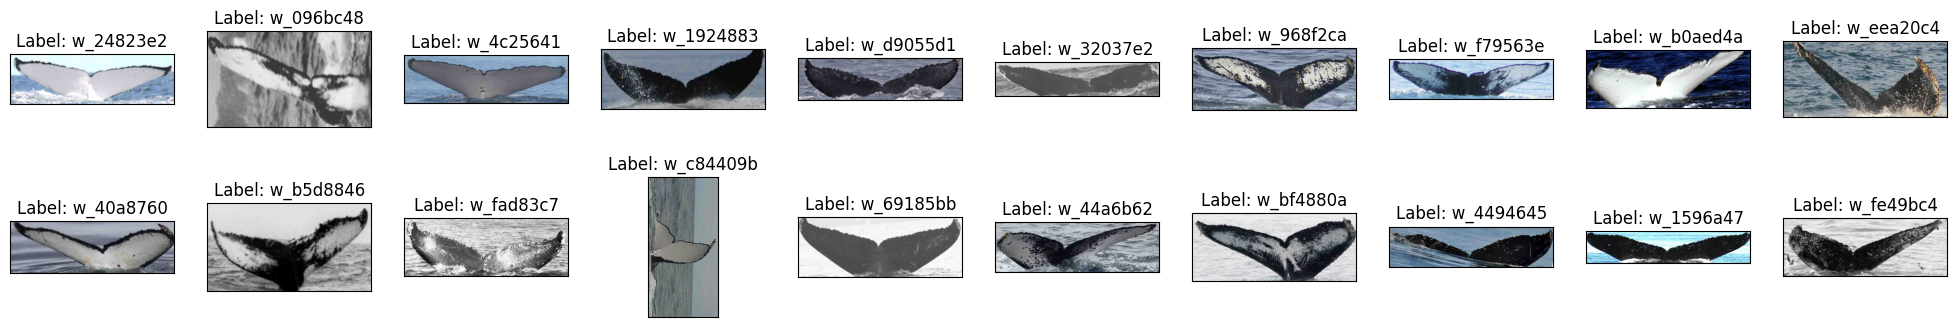

In [7]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("whale/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

In [8]:
train_df.Id.value_counts()

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
            ... 
w_6f504c0      1
w_2fdee7b      1
w_a0838d1      1
w_3698eaf      1
w_b9bfd4e      1
Name: Id, Length: 4251, dtype: int64

In [9]:
len(train_df['Id'].unique())

4251

In [10]:
train_df[train_df['Id'] == 'new_whale']

,Image,Id
7,0031c258.jpg,new_whale
19,007c3603.jpg,new_whale
20,00863b8c.jpg,new_whale
26,00aa021c.jpg,new_whale
30,00ad9219.jpg,new_whale
...,...,...
9794,fe9264a2.jpg,new_whale
9802,feb1ecd3.jpg,new_whale
9820,ff2d0d82.jpg,new_whale
9837,ffb71ac2.jpg,new_whale


In [11]:
train_df

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
...,...,...
9845,ffe5c306.jpg,w_2ceab05
9846,ffeaa7a4.jpg,w_b067417
9847,ffecec63.jpg,w_8b56cb1
9848,fff04277.jpg,w_2dcbf82


In [10]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2220 classes with 1 samples in train data.
There are 1034 classes with 2 samples in train data.
There are 492 classes with 3 samples in train data.


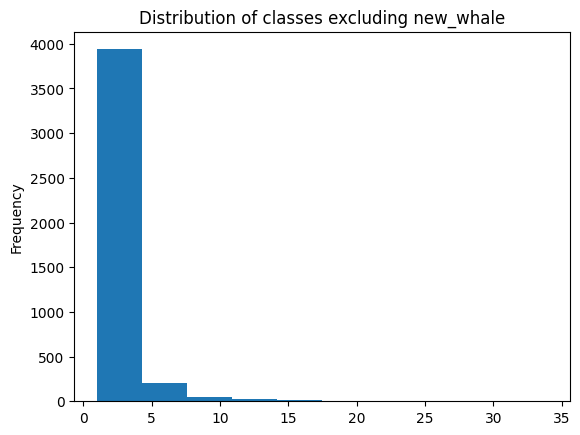

In [11]:
plt.title('Distribution of classes excluding new_whale');
train_df.Id.value_counts()[1:].plot(kind='hist');

We can see that there is a huge disbalance in the data. There are many classes with only one or several samples , some classes have 50+ samples and "default" class has almost 10k samples.

At least some images are quite big

## Encoding labels
Labels need to be one-hot encoded.

In [4]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [5]:
y, le = prepare_labels(train_df['Id'])

C:\Users\MMC_JYB\anaconda3\envs\yb\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Dataset

Now we need to create a dataset. Sadly, default version won't work, as images for each class are supposed to be in separate folders. So I write a custom WhaleDataset.

In [6]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform=None, y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((4251,))

        image = np.array(Image.open(img_name).convert('RGB'))
        image = self.transform(image=image)["image"]
        # image = image.mean(dim=0, keepdim=True)
        
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [21]:
data_transforms = A.Compose([
                            A.Resize(256, 256),
                            A.Crop(x_min=0, y_min=0, x_max=256, y_max=195),
                            A.Resize(256, 256),
                            A.HorizontalFlip(p=0.5),
                            A.OneOf([
                                A.CLAHE(clip_limit=0.2, tile_grid_size=(3, 3), p=0.7),
                                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5)
                            ], p=0.5),                            
                            A.Rotate(limit=15, p=0.5),
                            A.OneOf([
                                A.MotionBlur(blur_limit=7, allow_shifted=True, always_apply=False, p=0.5),
                                A.Downscale(scale_min=0.4, scale_max=0.8, interpolation=2, p=0.5)
                            ], p=0.3),
                            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            # A.OneOf([
                                # A.ChannelShuffle(p=0.5),
                                A.ToGray(p=0.5),
                            # ], p=0.5),
                            ToTensorV2()
])

data_transforms_test = A.Compose([
                                   A.Resize(256, 256),
                                   A.Normalize([0.485 , 0.456, 0.406], [0.229, 0.224 , 0.225]),
                                   # A.ToGray(p=1),
                                   ToTensorV2()
])

In [22]:
train_dataset = WhaleDataset(datafolder='whale/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='test_yolo/', datatype='test', transform=data_transforms_test)

In [23]:
train_sampler = SubsetRandomSampler(list(range(len(os.listdir('train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('test')))))
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)

In [25]:
# def imshow(img):
#     MEAN = np.array([0.485 , 0.456, 0.406])
#     STD = np.array([0.229, 0.224 , 0.225])
#     img = img * STD[:, None, None] + MEAN[:, None, None]   # 시각화 위해 unnormalize 해주기
#     plt.imshow(np.clip(np.transpose(img, (1, 2, 0)), 0, 1)) # imshow 위해 형변환 하여 시각화
    
# data, label =  next(iter(train_loader)) # train loader로부터 가져와 시각화
# print(data.shape, label.shape)

# fig = plt.figure(figsize=(15, 4))
# # display 20 images
# data = data.numpy()
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
#     imshow(data[idx])

## Initializing model

We need to define model, loss, oprimizer and possibly a scheduler.

In [19]:
model_conv = timm.create_model('efficientnet_b0', pretrained=True)
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 4251)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
n_epochs = 40
optimizer = optim.Adam(model_conv.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0) 

In [20]:
model_conv = model_conv.cuda()

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.10f}') # 매 epoch마다 Learning Rate 출력

    train_loss = []

    for batch_i, (data, target) in enumerate(tqdm.tqdm(train_loader)):
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        
    avg_train_loss = np.mean(train_loss)
    # exp_lr_scheduler.step(avg_train_loss) 
    exp_lr_scheduler.step()
    
    print(f'Epoch {epoch}, train loss: {avg_train_loss:.8f}')
    torch.save(model_conv, f'model.pth')

Tue Dec  5 14:02:22 2023 Epoch: 1
Learning Rate: 0.0010000000


 99%|█████████▊| 152/154 [00:47<00:00,  3.19it/s]

KeyboardInterrupt



## Inference

In [17]:
model1 = torch.load('model/model_resnet50.pth')
model2 = torch.load('model/model_effb0.pth')
model3 = torch.load('model/model_effb0_2.pth')
model4 = torch.load('model.pth')

In [20]:
import pandas as pd
import torch
import tqdm

model1.eval()
model2.eval()
model3.eval()
model4.eval()

sub = pd.read_csv('sample_submission.csv')

for (data, _, name) in tqdm.tqdm(test_loader):
    data = data.cuda()

    with torch.no_grad():
        output1 = model1(data).cpu().numpy()
        output2 = model2(data).cpu().numpy()
        output3 = model3(data).cpu().numpy()
        output4 = model4(data).cpu().numpy()

    final_output = (output1 + output2 + output3 + output4) / 4

    for i, (e, n) in enumerate(zip(final_output, name)):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))

sub.to_csv('submission.csv', index=False)

100%|██████████| 488/488 [02:18<00:00,  3.53it/s]
